## Modèle

In [1]:
#pip install yfinance

On va prédire les prix pour Amazon.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.models import load_model
%matplotlib inline
#from notify_run import Notify # pour m'envoyer des notification

C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [3]:
#notify = Notify()
#notify.register()

### Importation des données

In [4]:
def get_data(symbol):
  tickerData = yf.Ticker(symbol)
  data = tickerData.history(period='1d', start='2010-10-1', end="2020-9-29")
  data['companies'] = symbol
  data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
  return data



In [5]:
msft = get_data("MSFT")
amzn = get_data("AMZN")
goog = get_data("GOOG")

In [6]:
msft.head()

,Open,High,Low,Close,Volume,companies
Date,,,,,,
2010-09-30,19.50,19.67,19.30,19.40,61262700,MSFT
2010-10-01,19.62,19.66,19.25,19.32,62672300,MSFT
2010-10-04,18.98,19.01,18.84,18.94,98143400,MSFT
2010-10-05,19.06,19.37,18.94,19.29,78152900,MSFT
2010-10-06,19.27,19.44,19.12,19.36,50489700,MSFT


# Rassembler les 3 sociétés dans le meme dataframe 

In [7]:

company_list = [msft, amzn, goog]

    
df_concat = pd.concat(company_list, axis=0)
    
df_concat.head()

,Open,High,Low,Close,Volume,companies
Date,,,,,,
2010-09-30,19.50,19.67,19.30,19.40,61262700,MSFT
2010-10-01,19.62,19.66,19.25,19.32,62672300,MSFT
2010-10-04,18.98,19.01,18.84,18.94,98143400,MSFT
2010-10-05,19.06,19.37,18.94,19.29,78152900,MSFT
2010-10-06,19.27,19.44,19.12,19.36,50489700,MSFT


In [8]:
df_concat.companies.unique()

array(['MSFT', 'AMZN', 'GOOG'], dtype=object)

# Split data 

In [9]:
def split_data(df, symbol):
  data = df.filter(['Close']).loc[df['companies']== symbol]
  dataset = data.values.reshape(-1, 1)
  training_data_len = int(np.ceil(len(dataset) * .8 ))
  print(f'Longueur du data: {training_data_len}')
  print('================================================')
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data= scaler.fit_transform(dataset)
  train_data = scaled_data[0:int(training_data_len), :]
  x_train = []
  y_train = []
  for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  test_data = scaled_data[training_data_len - 60: , :]
  x_test = []
  y_test = dataset[training_data_len:, :]
  for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
  return x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len

# Fonction LSTM 

In [10]:
def algo_lstm(x_train, y_train, x_test, y_test, scaler, symbol):
  x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "MSFT")
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
  model.add(LSTM(50, return_sequences= False))
  model.add(Dense(25))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  history = model.fit(x_train, y_train, batch_size=25, epochs=30, validation_split=0.1)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)

  rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
  print('================================================')
  print(f'RMSE: {rmse}')
  print('================================================')
  train = data[:training_data_len]
  valid = data[training_data_len:]
  valid['Predictions'] = predictions

  plt.figure(figsize=(16,8))
  plt.title('Prédictions vs. valeurs réeles')
  plt.xlabel('Date', fontsize=18)
  plt.ylabel('Close USD ($)', fontsize=18)
  plt.plot(train['Close'])
  plt.plot(valid[['Close', 'Predictions']])
  plt.legend(['Train', 'Valeurs actuelles', 'Prédictions'], loc='lower right')
  plt.show()
  print('================================================')
  print(valid)
  modelFileName = 'model_{df}.h5'
  model.save(modelFileName) # saves the trained model
  print("Model saved.")
  #notify.send('It\'s done!')
  
  return model
  


# LSTM Microsft

In [11]:
 x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "MSFT")

Longueur du data: 2013


Longueur du data: 2013
Epoch 1/30
71/71 [==============================] - 8s 106ms/step - loss: 0.0011 - val_loss: 2.7498e-04
Epoch 2/30
71/71 [==============================] - 5s 64ms/step - loss: 3.1020e-05 - val_loss: 1.3176e-04
Epoch 3/30
71/71 [==============================] - 4s 63ms/step - loss: 3.1290e-05 - val_loss: 1.2558e-04
Epoch 4/30
71/71 [==============================] - 5s 69ms/step - loss: 2.9866e-05 - val_loss: 2.8323e-04
Epoch 5/30
71/71 [==============================] - 5s 66ms/step - loss: 2.9681e-05 - val_loss: 9.3333e-05
Epoch 6/30
71/71 [==============================] - 5s 69ms/step - loss: 2.8664e-05 - val_loss: 9.8388e-05
Epoch 7/30
71/71 [==============================] - 5s 74ms/step - loss: 3.1650e-05 - val_loss: 9.3545e-05
Epoch 8/30
71/71 [==============================] - 5s 66ms/step - loss: 2.9387e-05 - val_loss: 1.1756e-04
Epoch 9/30
71/71 [==============================] - 5s 70ms/step - loss: 2.8885e-05 - val_loss: 1.1582e-04
Epoch 10/30
71/71

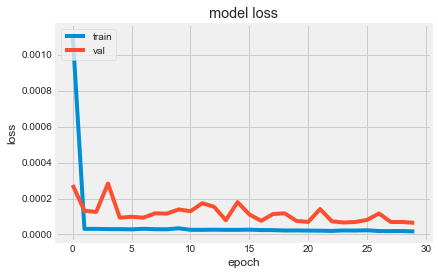

RMSE: 4.211884729163216


C:\Users\ouizb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


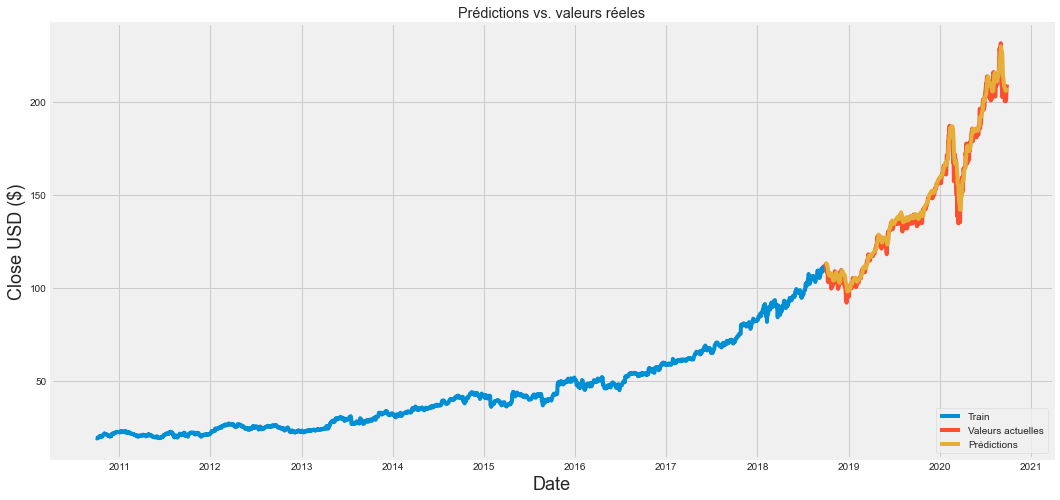

             Close  Predictions
Date                           
2018-09-28  111.33   112.577164
2018-10-01  112.54   112.648582
2018-10-02  112.09   112.903687
2018-10-03  112.11   113.109169
2018-10-04  109.80   113.263100
...            ...          ...
2020-09-22  207.42   205.956772
2020-09-23  200.59   206.644882
2020-09-24  203.19   206.412216
2020-09-25  207.82   206.411545
2020-09-28  209.44   207.364594

[503 rows x 2 columns]
Model saved.


In [12]:
model = algo_lstm(x_train, y_train, x_test, y_test, scaler, "MSFT")

# LSTM Google 

Longueur du data: 2013
Longueur du data: 2013
Epoch 1/30
71/71 [==============================] - 7s 93ms/step - loss: 0.0011 - val_loss: 1.0010e-04
Epoch 2/30
71/71 [==============================] - 5s 76ms/step - loss: 2.9798e-05 - val_loss: 9.4242e-05
Epoch 3/30
71/71 [==============================] - 4s 63ms/step - loss: 3.2185e-05 - val_loss: 9.4742e-05
Epoch 4/30
71/71 [==============================] - 7s 94ms/step - loss: 3.2957e-05 - val_loss: 1.0048e-04
Epoch 5/30
71/71 [==============================] - 6s 90ms/step - loss: 3.0029e-05 - val_loss: 1.3672e-04
Epoch 6/30
71/71 [==============================] - 6s 82ms/step - loss: 2.8577e-05 - val_loss: 1.0033e-04
Epoch 7/30
71/71 [==============================] - 5s 65ms/step - loss: 2.9471e-05 - val_loss: 9.0239e-05
Epoch 8/30
71/71 [==============================] - 6s 79ms/step - loss: 2.7317e-05 - val_loss: 1.6993e-04
Epoch 9/30
71/71 [==============================] - 5s 68ms/step - loss: 2.8011e-05 - val_loss: 8.9863

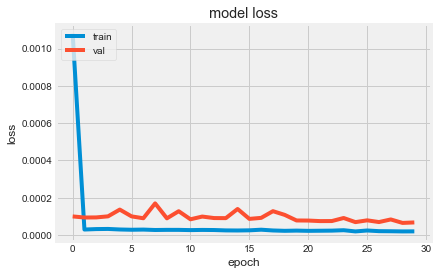

RMSE: 4.151564460381772


C:\Users\ouizb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


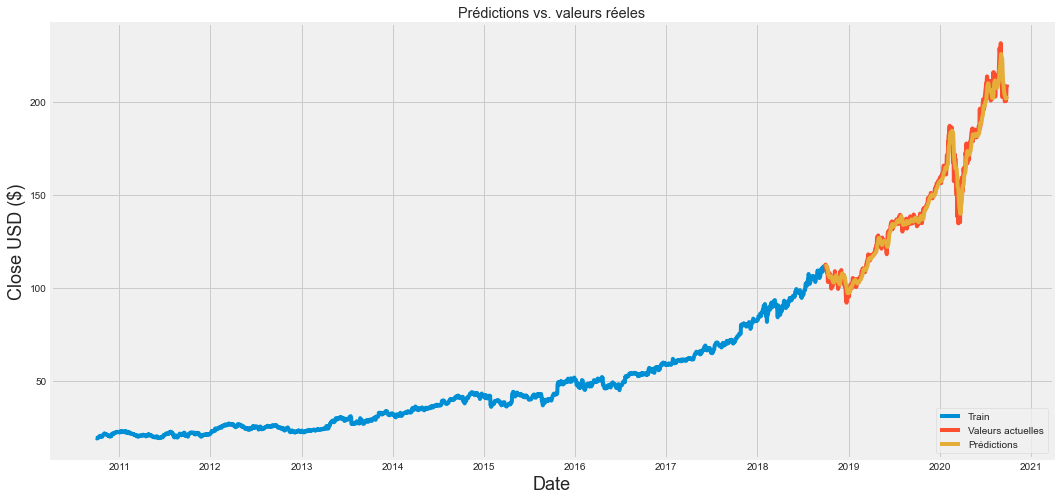

             Close  Predictions
Date                           
2018-09-28  111.33   111.293808
2018-10-01  112.54   111.396217
2018-10-02  112.09   111.636627
2018-10-03  112.11   111.837044
2018-10-04  109.80   111.992889
...            ...          ...
2020-09-22  207.42   201.872360
2020-09-23  200.59   202.326126
2020-09-24  203.19   202.127716
2020-09-25  207.82   202.141678
2020-09-28  209.44   202.988129

[503 rows x 2 columns]
Model saved.


In [13]:
x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "GOOG")
model = algo_lstm(x_train, y_train, x_test, y_test, scaler, "GOOG")

# LSTM Amazon

Longueur du data: 2013
Longueur du data: 2013
Epoch 1/30
71/71 [==============================] - 8s 114ms/step - loss: 0.0011 - val_loss: 1.1359e-04
Epoch 2/30
71/71 [==============================] - 6s 81ms/step - loss: 3.8027e-05 - val_loss: 9.5194e-05
Epoch 3/30
71/71 [==============================] - 6s 79ms/step - loss: 3.3976e-05 - val_loss: 1.0126e-04
Epoch 4/30
71/71 [==============================] - 6s 80ms/step - loss: 3.1514e-05 - val_loss: 9.2666e-05
Epoch 5/30
71/71 [==============================] - 6s 83ms/step - loss: 3.0008e-05 - val_loss: 1.0135e-04
Epoch 6/30
71/71 [==============================] - 6s 83ms/step - loss: 3.3907e-05 - val_loss: 8.9196e-05
Epoch 7/30
71/71 [==============================] - 6s 81ms/step - loss: 3.1185e-05 - val_loss: 1.0345e-04
Epoch 8/30
71/71 [==============================] - 6s 84ms/step - loss: 2.7887e-05 - val_loss: 8.7878e-05
Epoch 9/30
71/71 [==============================] - 6s 84ms/step - loss: 2.6358e-05 - val_loss: 2.115

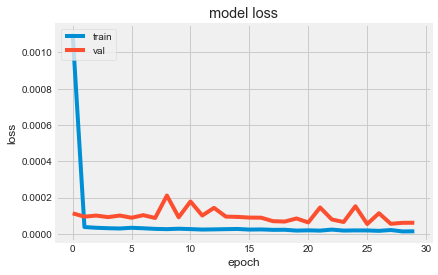

RMSE: 3.788403646791979


C:\Users\ouizb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


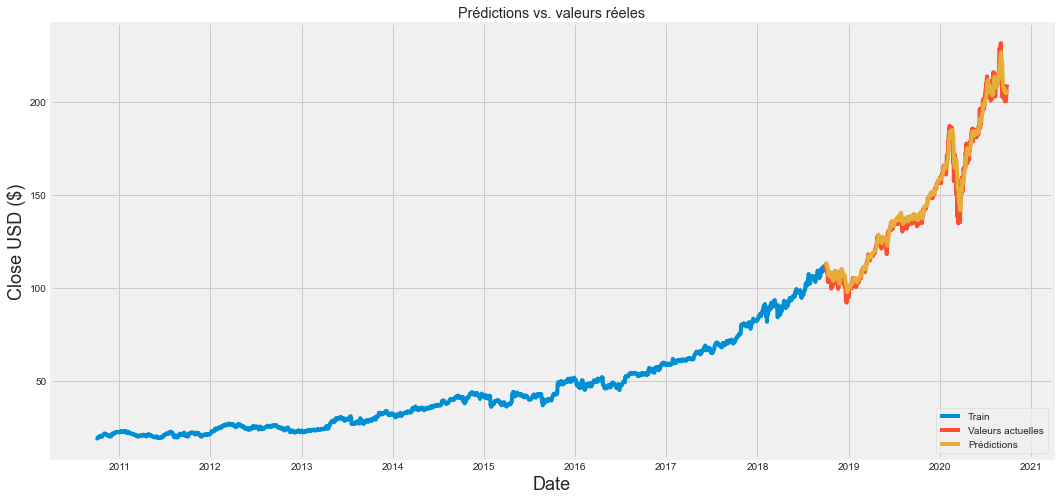

             Close  Predictions
Date                           
2018-09-28  111.33   112.529991
2018-10-01  112.54   112.550163
2018-10-02  112.09   112.878723
2018-10-03  112.11   113.116310
2018-10-04  109.80   113.269577
...            ...          ...
2020-09-22  207.42   204.724365
2020-09-23  200.59   205.726471
2020-09-24  203.19   205.195145
2020-09-25  207.82   204.991806
2020-09-28  209.44   206.083649

[503 rows x 2 columns]
Model saved.


In [14]:
x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "AMZN")
model = algo_lstm(x_train, y_train, x_test, y_test, scaler, "AMZN")

# Pridction du Prix du lendemain (le 29/09/2020)

In [15]:
def predict_price(symbol):
    tickerData = yf.Ticker(symbol)
    df = tickerData.history(period='1d', start='2010-10-1', end="2020-9-30")
    new_df = df.filter(['Close'])
    last_60_days = new_df[-60:].values
    scaler =  MinMaxScaler()

    last_60_days_scaled = scaler.fit_transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    print(f'Prix prédit: {pred_price}')

    actual_price = tickerData.history(period='1d', start="2020-9-29", end="2020-9-30")
    actual_price = actual_price.Close.values
    actual_price = np.array(actual_price)
    print(f'Prix réel: {actual_price}')
    return pred_price, actual_price

In [16]:
predict_price("MSFT")

Prix prédit: [[208.00793]]
Prix réel: [209.44 207.26]


(array([[208.00793]], dtype=float32), array([209.44, 207.26]))

In [17]:
predict_price("AMZN")

Prix prédit: [[3138.9421]]
Prix réel: [3174.05 3144.88]


(array([[3138.9421]], dtype=float32), array([3174.05, 3144.88]))

In [18]:
predict_price("GOOG")

Prix prédit: [[1460.9755]]
Prix réel: [1464.52 1469.33]


(array([[1460.9755]], dtype=float32), array([1464.52, 1469.33]))